<a href="https://colab.research.google.com/github/Reevoc/Tesi/blob/main/Tumori_DCGAN_35GB_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DCGAN

##Libreire 

In [115]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
import os
import errno

from keras import backend
from google.colab import drive
from PIL import Image
from IPython import display
from tensorflow.keras import layers

In [116]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ltdige79
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ltdige79
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0a7be335a8581d61c3362ed13f3bdeb786241c5c4_-cp36-none-any.whl size=146718 sha256=4dc4278c4169c62cf65138917e5e6fd0bfd7a7b4b15974a072a29977ef24dad0
  Stored in directory: /tmp/pip-ephem-wheel-cache-ae_ib3f0/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


##Upload dei dati da Drive

In [117]:
drive.mount('/content/drive', force_remount = True)

folder_benign_train = '/content/drive/MyDrive/Dati/train/benign'
folder_malignant_train = '/content/drive/MyDrive/Dati/train/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))

# Carico le immagini di train
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
print("train beningi caricati")

Mounted at /content/drive


KeyboardInterrupt: ignored

###Carica o salva il modello 


In [ ]:
def save_model(epoch, generator):
  try: 
    os.mkdir('/content/drive/My Drive/GansCheckpoint/DCGANh5/Gmodel%01d.h5')
  except OSError as e:
    if e.errno == errno.EEXIST:
        print('Folder not create or already exist')
  filename = '/content/drive/My Drive/GansCheckpoint/DCGANh5/Gmodel%01d.h5' %(epoch)
  generator.save(filename)

def load_model(epoch, generator):
      epoch = epoch
      filename = '/content/drive/My Drive/GansCheckpoint/DCGANh5/Gmodel%01d.h5' %(self.epoch)
      generator.load_model(filename)

#**Normalizzazione dei dati** 
Preparo i dati dati per essere utilizzati 
1.   Faccio un reshape e converto in float32
2.   Nomalizzo i dati affinche siano compresi tra i valori 0 e 1
3.   Creo il dataset aggiungedi la dimensione di batch



In [ ]:
X_benign = X_benign.reshape(X_benign.shape[0], 224, 224, 3).astype('uint8')

print(f'la dimesione =>{X_benign.shape}')
print(f'il numerdo di dimesion =>{X_benign.ndim}') 

X_benign = X_benign  / 255

# Batch and shuffle the data
BUFFER_SIZE = 40000
BATCH_SIZE = 64
train_benign = tf.data.Dataset.from_tensor_slices(X_benign).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



#Lables Smoothing

In [ ]:
# Label smoothing -- technique from GAN hacks, instead of assigning 1/0 as class labels, we assign a random integer in range [0.7, 1.0] for positive class
# and [0.0, 0.3] for negative class
def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.5)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.3

# randomly flip some labels
def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * int(y.shape[0]))
    # choose labels to flip
    flip_ix = np.random.choice([i for i in range(int(y.shape[0]))], size=n_select)
    
    op_list = []
    # invert the labels in place
    #y_np[flip_ix] = 1 - y_np[flip_ix]
    for i in range(int(y.shape[0])):
        if i in flip_ix:
            op_list.append(tf.subtract(1, y[i]))
        else:
            op_list.append(y[i])
    
    outputs = tf.stack(op_list)
    return outputs

#**Generatore** 
Il generatore utilizza Conv2DTranspose per produrre un'immagine da un seme (rumore casuale). Inizia con un livello Dense che prende questo seme come input, quindi sovracampiona più volte fino a raggiungere la dimensione dell'immagine desiderata di 224x224x3.

In [ ]:
def make_generator_model_tensorflow(filter, kernel_size):
    #kernel size (5,5) , filter 1 
    model = tf.keras.Sequential()
    model.add(layers.Dense(56*56*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((56, 56, 256)))
    assert model.output_shape == (None, 56, 56, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 112, 112, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filter, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 3)
    model.summary()

    return model

###Test funzionamento generatore
utilizzo il generatore non ancora addestrato per generare un immagine a rumore comletamente casuale

In [ ]:
generator = make_generator_model_tensorflow(3, (5,5))

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#**Discriminatore**
Il discriminatoreè un semplice modello basato su una CNN che si occuperà di discriminare le immagini false da quelle vere. 
Lobbiettivo della rete gan sarà ingannare il discriminatore creando immagini sempre migliori

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
     input_shape=[224,224,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

###Uso del discriminatore

Usa il discriminatore (non ancora addestrato) per classificare le immagini generate come reali o false. Il modello verrà addestrato per produrre valori positivi per immagini reali e valori negativi per immagini false.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

#Perdita Ottimizzatori 

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output, loss_func, apply_label_smoothing=True, label_noise=True):
    if label_noise and apply_label_smoothing:
      real_output_noise = noisy_labels(tf.ones_like(real_output), 0.05)
      fake_output_noise = noisy_labels(tf.zeros_like(fake_output), 0.05)
      real_output_smooth = smooth_positive_labels(real_output_noise)
      fake_output_smooth = smooth_negative_labels(fake_output_noise)
      if loss_func == 'gan': 
          real_loss = cross_entropy(tf.ones_like(real_output_smooth), real_output)
          fake_loss = cross_entropy(tf.zeros_like(fake_output_smooth), fake_output)
    else:
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output, real_output, loss_func, apply_label_smoothing=False):
  if apply_label_smoothing:
        fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
        if loss_func == 'gan':
            return cross_entropy(tf.ones_like(fake_output_smooth), fake_output)
        else:
            return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
lr_initial_g = 0.0002
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr_initial_g, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = lr_initial_g, beta_1 = 0.5)

###Salva i checkpoint
Salvo i checkpoit, può essere utile nel caso in cui venga interrotta un'attività di addestramento di lunga durata.

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/GansCheckpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
manager = tf.train.CheckpointManager(checkpoint, '/content/drive/MyDrive/GansCheckpoint', max_to_keep=3)

#**Ciclo di addestramento** 

In [ ]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])


Il ciclo di addestramento inizia con il generatore che riceve un seme casuale come input. Quel seme viene utilizzato per produrre un'immagine. Il discriminatore viene quindi utilizzato per classificare immagini reali (tratte dal set di addestramento) e immagini false (prodotte dal generatore). La perdita viene calcolata per ciascuno di questi modelli e i gradienti vengono utilizzati per aggiornare il generatore e il discriminatore.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

def train_step(images, loss_type = 'gan'):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      
      generated_images = generator(noise,
                                   training=True)

      real_output = discriminator(images, 
                                  training=True)
      fake_output = discriminator(generated_images,
                                  training=True)

      gen_loss = generator_loss(fake_output = fake_output,
                                real_output= real_output,
                                loss_func = 'gan',
                                apply_label_smoothing = True)
      
      disc_loss = discriminator_loss(real_output = real_output,
                                     fake_output = fake_output, 
                                     loss_func = 'gan',
                                     apply_label_smoothing = True,
                                     label_noise = True)
      
    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                    discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                discriminator.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs, manager):
  
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  all_gl = np.array([]); all_dl = np.array([])
  lr_initial_g = 0.0002
  lr_initial_d = 0.0002
  for epoch in range(epochs):
    start = time.time()
    G_loss = []; D_loss = []
    
    new_lr_d = lr_initial_d
    new_lr_g = lr_initial_g
    global_step = 0


    for image_batch in dataset:
      
      global_step = global_step + 1
      g_loss, d_loss = train_step(image_batch)
      G_loss.append(g_loss); D_loss.append(d_loss)
      all_gl = np.append(all_gl,np.array([G_loss]))
      all_dl = np.append(all_dl,np.array([D_loss]))
    
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    if (epoch + 1) % 5 == 0:
      plot_losses(G_loss, D_loss, all_gl, all_dl, epoch + 1)
    # Save the model every 5 epochs and show gen e disc loss
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    #!
    decay_step = 50
    replay_step = 50
    lr_decay_steps = 1000
    if (epoch + 1) % decay_step == 0:
            new_lr_d = tf.compat.v1.train.cosine_decay(new_lr_d,
                                             min(global_step, lr_decay_steps),
                                             lr_decay_steps)
            new_lr_g = tf.compat.v1.train.cosine_decay(new_lr_g,
                                             min(global_step, lr_decay_steps),
                                              lr_decay_steps)
            generator_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=new_lr_d, beta1=0.5)
            discriminator_optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=new_lr_g, beta1=0.5)          

    print('Epoch: {} computed for {} sec'.format(epoch + 1, time.time() - start))
    print('Gen_loss mean: ', np.mean(G_loss),' std: ', np.std(G_loss))
    print('Disc_loss mean: ', np.mean(D_loss),' std: ', np.std(D_loss))
      #!

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)
  
  #save the image created at the end of the train
  try:
    os.mkdir('/content/drive/MyDrive/GansCheckpoint/images')
    save_images('/content/drive/MyDrive/GansCheckpoint/images')
  except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory not created or alreasy exist')
        save_images('/content/drive/MyDrive/GansCheckpoint/images')
  
  #salva il modello 
  save_model(epochs, generator)  

In [ ]:
def plot_losses(G_losses, D_losses, all_gl, all_dl, epoch):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    ymax = plt.ylim()[1]
    plt.show()
    
    plt.figure(figsize=(10,5))
    plt.plot(np.arange(len(all_gl)),all_gl,label='G')
    plt.plot(np.arange(len(all_dl)),all_dl,label='D')
    plt.legend()
    #plt.ylim((0,np.min([1.1*np.max(all_gl),2*ymax])))
    plt.title('All Time Loss')
    plt.show()

###Genera e salva immagini


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap = 'gray') #* 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  #salvare immagini generate dentro un file ?
  plt.show()

#**Addestra il modello**
Chiama il metodo train() definito sopra per addestrare il generatore e il discriminatore simultaneamente. È importante che il generatore e il discriminatore non si superino a vicenda cioè si devono alleare a un ritmo simile.

All'inizio della formazione, le immagini generate sembrano rumori casuali. Con il progredire della formazione, le cifre generate appariranno sempre più reali. Dopo circa 50 epoche generalemte le immagini iniziano ad avere una forma simile a quelle da noi cericate.

In [ ]:
def zip_images(filename='images.zip'):
    # SAVE TO ZIP FILE NAMED IMAGES.ZIP
    z = zipfile.PyZipFile(filename, mode='w')
    for k in range(image_sample_size):
        generated_image = generator(tf.random.normal([1, noise_dim]), training=False)
        f = str(k)+'.png'
        img = np.array(generated_image)
        img = (img[0, :, :, :] + 1.) / 2.
        img = Image.fromarray((255*img).astype('uint8').reshape((image_height,image_width,image_channels)))
        img.save(f,'PNG')
        z.write(f)
        os.remove(f)
        #if k % 1000==0: print(k)
    z.close()
    print('Saved final images for submission.')
    
def save_images(directory):
  #devo mettere il numero di sample che voglio generare 
    for k in range(100):
        #devo mettere il mio generatore
        generated_image = generator(tf.random.normal([1, noise_dim]), training=False)
        f = str(k)+'.png'
        f = os.path.join(directory, f)
        img = np.array(generated_image)
        img = (img[0, :, :, :] + 1.) / 2.
        #devo fare il reshape con i valori dell'immagine che ho 
        image_height = 224  
        image_width = 224 
        image_channels = 3
        img = Image.fromarray((255*img).astype('uint8').reshape((image_height, image_width, image_channels)))
        img.save(f,'PNG')
        #if k % 1000==0: print(k)
    print('Saved temporary images for evaluation.')

In [ ]:
train(train_benign, EPOCHS, manager)

#Crea una GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Usa imageio per creare una gif animata utilizzando le immagini salvate durante l'allenamento.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

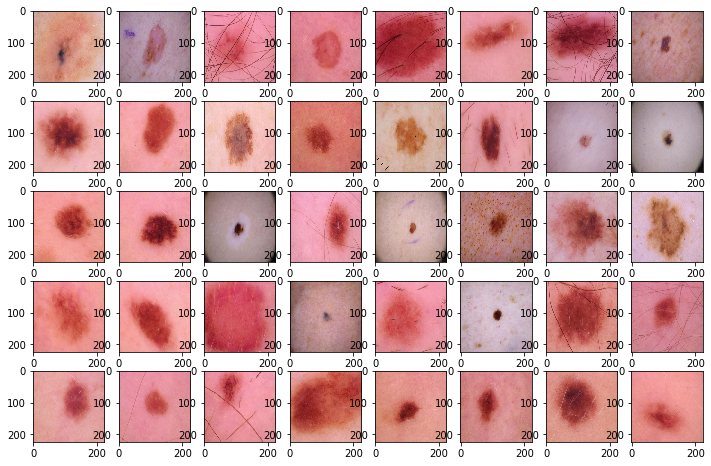

In [120]:
columns = 8
rows = 5
fig=plt.figure(figsize=(12, 8))

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(X_benign[i], interpolation= 'nearest')
plt.show()

In [127]:
folder_generated = '/content/drive/MyDrive/GansCheckpoint/images'

read = lambda imname: np.asarray(Image.open(imname).convert('RGB'))

# Carico le immagini di train
ims_genereted = [read(os.path.join(folder_generated, filename)) for filename in os.listdir(folder_generated)]
X_generated = np.array(ims_genereted, dtype='uint8')
print("train beningi caricati")

train beningi caricati


In [129]:
X_generated = X_generated.reshape(X_generated.shape[0], 224, 224, 3).astype('uint8')

print(f'la dimesione =>{X_generated.shape}')
print(f'il numerdo di dimesion =>{X_generated.ndim}') 

X_generated= X_generated  / 255

la dimesione =>(100, 224, 224, 3)
il numerdo di dimesion =>4


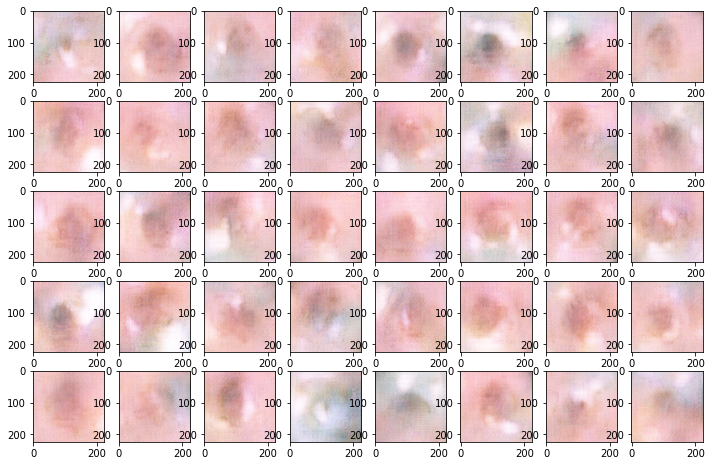

In [130]:
columns = 8
rows = 5
fig=plt.figure(figsize=(12, 8))

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    plt.imshow(X_generated[i], interpolation= 'nearest')
plt.show()